# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# data Loading

In [82]:
data_path = "https://raw.githubusercontent.com/DriveMyScream/Multiple_Stock_Price_Prediction/main/BNB_USD%20Binance%20Historical%20Data.csv"
dataset = pd.read_csv(data_path, parse_dates=['Date'])
dataset.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-05-15,313.7,312.0,314.4,310.7,212.75K,0.51%
1,2023-05-14,312.1,310.8,314.7,309.5,192.93K,0.45%
2,2023-05-13,310.7,308.7,311.8,307.6,151.65K,0.68%
3,2023-05-12,308.6,307.6,309.0,301.3,327.02K,0.36%
4,2023-05-11,307.5,314.3,314.4,304.5,291.86K,-2.16%


In [83]:
dataset = dataset[::-1]
dataset.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1960,2018-01-01,8.45,8.53,8.70,7.80,642.51K,-0.94%
1959,2018-01-02,8.72,8.45,9.11,8.09,1.23M,3.20%
1958,2018-01-03,9.30,8.72,9.47,8.27,926.41K,6.65%
1957,2018-01-04,9.14,9.30,9.46,8.56,918.41K,-1.72%
1956,2018-01-05,14.88,9.14,16.82,8.97,2.60M,62.80%


In [84]:
def parse_float(string_value):
  cleaned_string = string_value.replace(",", "")
  float_value = float(cleaned_string)
  return float_value

In [85]:
dataset['Open'] = dataset['Open'].astype(str).apply(parse_float)
dataset['High'] = dataset['High'].astype(str).apply(parse_float)
dataset['Low'] = dataset['Low'].astype(str).apply(parse_float)
dataset['Price'] = dataset['Price'].astype(str).apply(parse_float)

In [86]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 1960 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1961 non-null   datetime64[ns]
 1   Price     1961 non-null   float64       
 2   Open      1961 non-null   float64       
 3   High      1961 non-null   float64       
 4   Low       1961 non-null   float64       
 5   Vol.      1961 non-null   object        
 6   Change %  1961 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 107.4+ KB


In [87]:
dataset.describe()

,Price,Open,High,Low
count,1961.000000,1961.000000,1961.000000,1961.000000
mean,161.850408,161.719363,166.545370,156.578088
std,181.959600,182.007849,187.341527,176.085453
min,4.520000,4.510000,4.600000,4.130000
25%,15.180000,15.150000,15.720000,14.670000
50%,29.270000,29.110000,29.980000,28.360000
75%,308.400000,308.300000,315.000000,300.700000
max,676.120000,677.410000,684.830000,637.040000


In [88]:
dataset.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

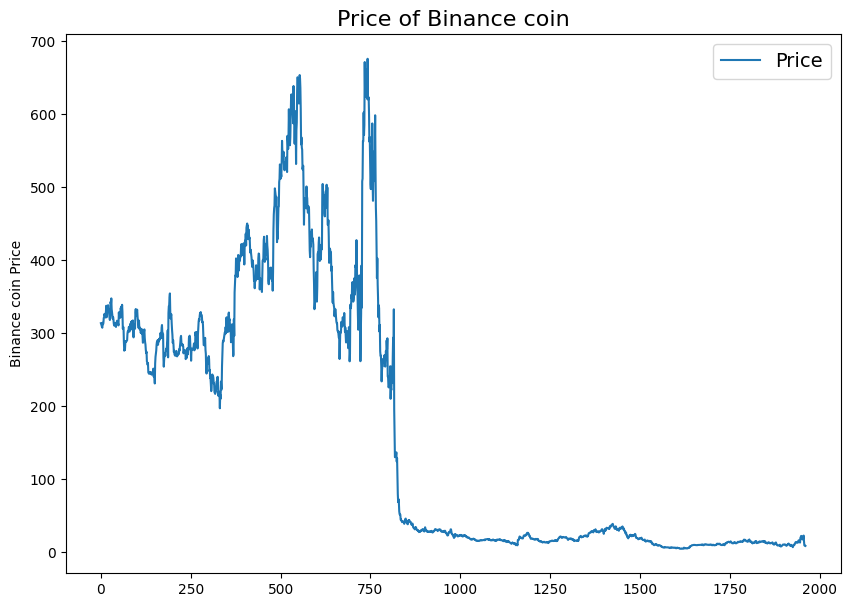

In [89]:
import matplotlib.pyplot as plt
dataset['Price'].plot(figsize=(10, 7))
plt.ylabel("Binance coin Price")
plt.title("Price of Binance coin", fontsize=16)
plt.legend(fontsize=14);

In [90]:
price_data = dataset['Price'].values
price_data

array([  8.45,   8.72,   9.3 , ..., 310.7 , 312.1 , 313.7 ])

In [91]:
price_data.shape

(1961,)

In [92]:
train_data, test_data = price_data[0:1800], price_data[1800:]

In [93]:
train_data.shape, test_data.shape

((1800,), (161,))

In [94]:
def windowed_dataset(series, time_step):
    dataX, dataY = [], []
    for i in range(len(series) - time_step - 1):
        a = series[i : i + time_step]  # Remove the indexing with ", 0"
        dataX.append(a)
        dataY.append(series[i + time_step])
        
    return np.array(dataX), np.array(dataY)

In [95]:
X_train, y_train = windowed_dataset(train_data, time_step=7)
X_test, y_test = windowed_dataset(test_data, time_step=7)

In [96]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1792, 7), (1792,), (153, 7), (153,))

In [97]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape) 
print(X_test.shape)

(1792, 7, 1)
(153, 7, 1)


In [98]:
X_train[0]

array([[ 8.45],
       [ 8.72],
       [ 9.3 ],
       [ 9.14],
       [14.88],
       [22.6 ],
       [18.59]])

In [99]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [100]:
# Create the LSTM model
model = models.Sequential()

model.add(layers.Input(shape = (7, 1), dtype=tf.float32))
# Add the Normalization layer
model.add(layers.Normalization())

# Specify the mean and variance for normalization
model.layers[0].adapt(X_train)

model.add(layers.LSTM(units=100, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.4))

model.add(layers.LSTM(units=10, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units=1))

In [101]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 7, 1)             3         
 ion)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 7, 100)            40800     
                                                                 
 dropout_6 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_7 (LSTM)               (None, 7, 50)             30200     
                                                                 
 dropout_7 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_8 (LSTM)               (None, 10)                2440      
                                                      

In [102]:
model.compile(optimizer = 'adamax', loss = 'mse', metrics = 'mae')

In [103]:
# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, validation_split=0.1, epochs = 30, batch_size = 32, verbose=1, shuffle=False)

Epoch 1/30
51/51 [==============================] - 8s 58ms/step - loss: 54279.4336 - mae: 135.6101 - val_loss: 76987.8594 - val_mae: 275.7793
Epoch 2/30
51/51 [==============================] - 1s 18ms/step - loss: 54002.4258 - mae: 133.8648 - val_loss: 76528.1094 - val_mae: 274.9468
Epoch 3/30
51/51 [==============================] - 1s 18ms/step - loss: 53393.9570 - mae: 131.1295 - val_loss: 75707.1641 - val_mae: 273.4684
Epoch 4/30
51/51 [==============================] - 2s 30ms/step - loss: 50404.1445 - mae: 126.5030 - val_loss: 71470.1016 - val_mae: 265.7246
Epoch 5/30
51/51 [==============================] - 2s 36ms/step - loss: 35530.0391 - mae: 109.1957 - val_loss: 47818.7773 - val_mae: 217.3499
Epoch 6/30
51/51 [==============================] - 1s 25ms/step - loss: 10177.5771 - mae: 57.7283 - val_loss: 19484.7168 - val_mae: 137.6477
Epoch 7/30
51/51 [==============================] - 1s 25ms/step - loss: 9376.4727 - mae: 52.5451 - val_loss: 15654.9219 - val_mae: 122.9102
Ep

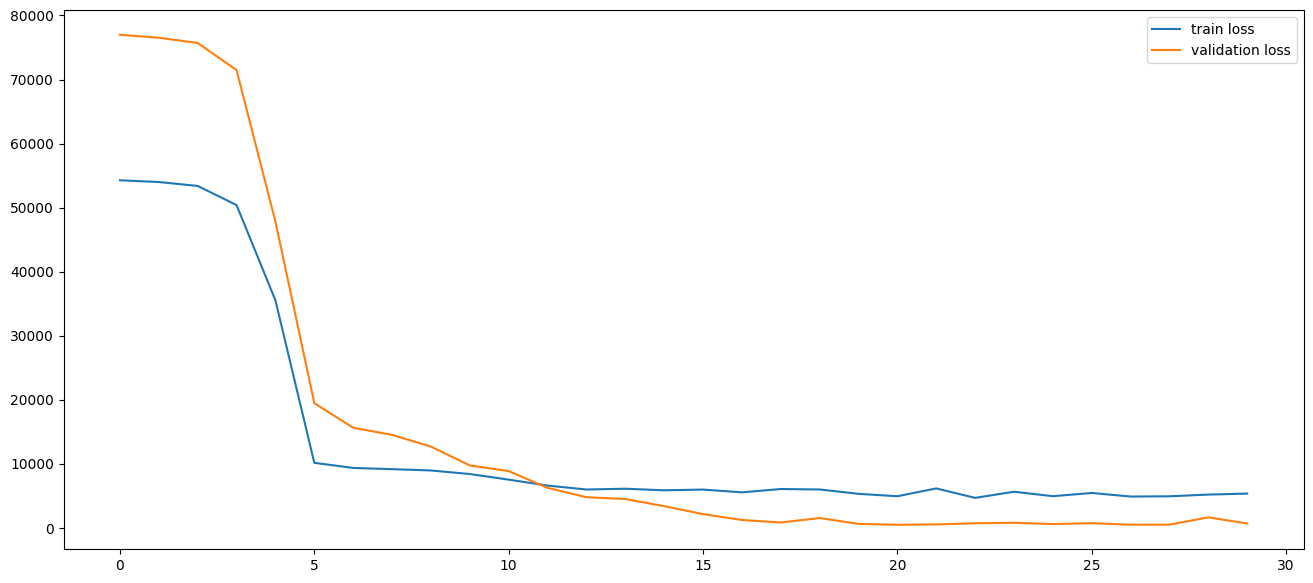

In [104]:
plt.figure(figsize=(16,7))
plt.plot(history.history["loss"], label= "train loss")
plt.plot(history.history["val_loss"], label= "validation loss")
plt.legend();

In [105]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 2s 9ms/step


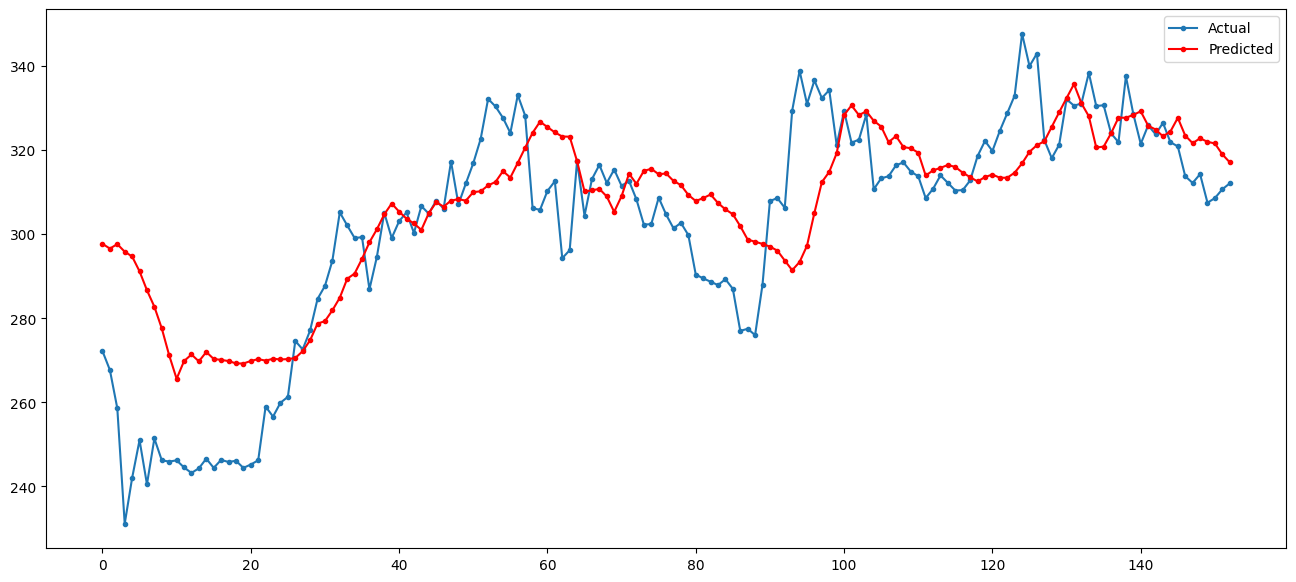

In [106]:
plt.figure(figsize=(16,7))
plt.plot(y_test.flatten(), marker='.', label="Actual")
plt.plot(test_predict.flatten(), 'r', marker='.', label="Predicted")
plt.legend();

In [107]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(y_train, train_predict))
test_RMSE = np.sqrt(mean_squared_error(y_test, test_predict))
train_MAE = np.sqrt(mean_absolute_error(y_train, train_predict))
test_MAE = np.sqrt(mean_absolute_error(y_test, test_predict))


print(f"Train RMSE: {train_RMSE}")
print(f"Train MAE: {train_MAE}")

print(f"Test RMSE: {test_RMSE}")
print(f"Test MAE: {test_MAE}")

Train RMSE: 29.822979971646216
Train MAE: 3.9799525429446447
Test RMSE: 17.368800160995406
Test MAE: 3.616672993536641


# at Inference

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [108]:
model.save("Binance_coin_Price_Prediction")

In [109]:
model = tf.keras.saving.load_model("/content/Binance_coin_Price_Prediction")

In [110]:
%cp -av /content/Binance_coin_Price_Prediction /content/drive/MyDrive/Multiple_Stock_Price_Prediction

'/content/Binance_coin_Price_Prediction' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/Binance_coin_Price_Prediction'
'/content/Binance_coin_Price_Prediction/variables' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/Binance_coin_Price_Prediction/variables'
'/content/Binance_coin_Price_Prediction/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/Binance_coin_Price_Prediction/variables/variables.data-00000-of-00001'
'/content/Binance_coin_Price_Prediction/variables/variables.index' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/Binance_coin_Price_Prediction/variables/variables.index'
'/content/Binance_coin_Price_Prediction/assets' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/Binance_coin_Price_Prediction/assets'
'/content/Binance_coin_Price_Prediction/fingerprint.pb' -> '/content/drive/MyDrive/Multiple_Stock_Price_Prediction/Binance_coin_Price_Prediction/fingerprint.pb'
'/content/Binance_

In [111]:
X_test[0].shape

(7, 1)

In [112]:
prices = np.array([[ 8.45],
       [ 8.72],
       [ 9.3 ],
       [ 9.14],
       [14.88],
       [22.6 ],
       [18.59]])

prices = prices.reshape(1, -1, 1)
prediction_price = model.predict(prices)
prediction_price = prediction_price[0][0]
print("Prediction Price: ", prediction_price)

1/1 [==============================] - 1s 930ms/step
Prediction Price:  16.27323


In [113]:
print("Predicted Binance coin Price: {0:.2f} ".format(prediction_price))

Predicted Binance coin Price: 16.27 
